In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 38.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
from huggingface_hub import login
login()

In [4]:
from datasets import load_dataset

# If the dataset is gated/private, make sure you have run huggingface-cli login
dataset = load_dataset("Expss4/chunk_train_seq")

Generating train split:   0%|          | 0/5556 [00:00<?, ? examples/s]

In [5]:
import numpy as np
from scipy.signal import resample, butter, sosfiltfilt, hilbert
import matplotlib.pyplot as plt

In [6]:
chunks = dataset['train']['chunk_seq']
chunks_np = []
for i in range(len(chunks)):
  chunks_np.append(np.array(chunks[i]))

In [7]:
label = dataset['train']['label']
label = [x[0] for x in label]

In [8]:
def std_scaling(data):
    std = np.std(data)
    mean = np.mean(data)
    scaled_data = (data-mean)/std
    return scaled_data

In [15]:
def bandpass_filter(data, cut_range=[13,30], order=2):
    # high order --> sharp cutoff
    sos = butter(order, cut_range, 'bandpass', fs=250, output='sos')
    filtered = sosfiltfilt(sos, data)

    return filtered

In [10]:
def select_event_period(data):
    # approx 1000 middle samples from data
    return data[367:-367]

In [11]:
def power(data):
    # square power
    return data ** 2

can add any filter or method you come up with

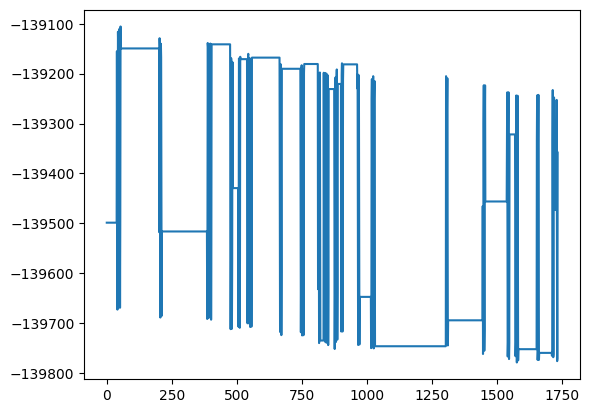

In [16]:
# example for 1 channel
plt.plot(chunks_np[0][:,1])

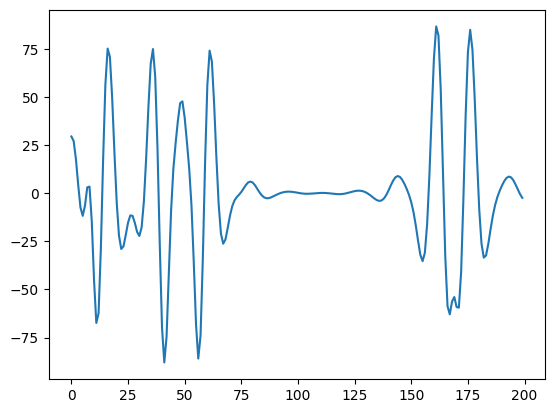

In [18]:
plt.plot(bandpass_filter(chunks_np[0][:,1]))

In [13]:
!pip install braindecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.2/165.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 83.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 5.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_

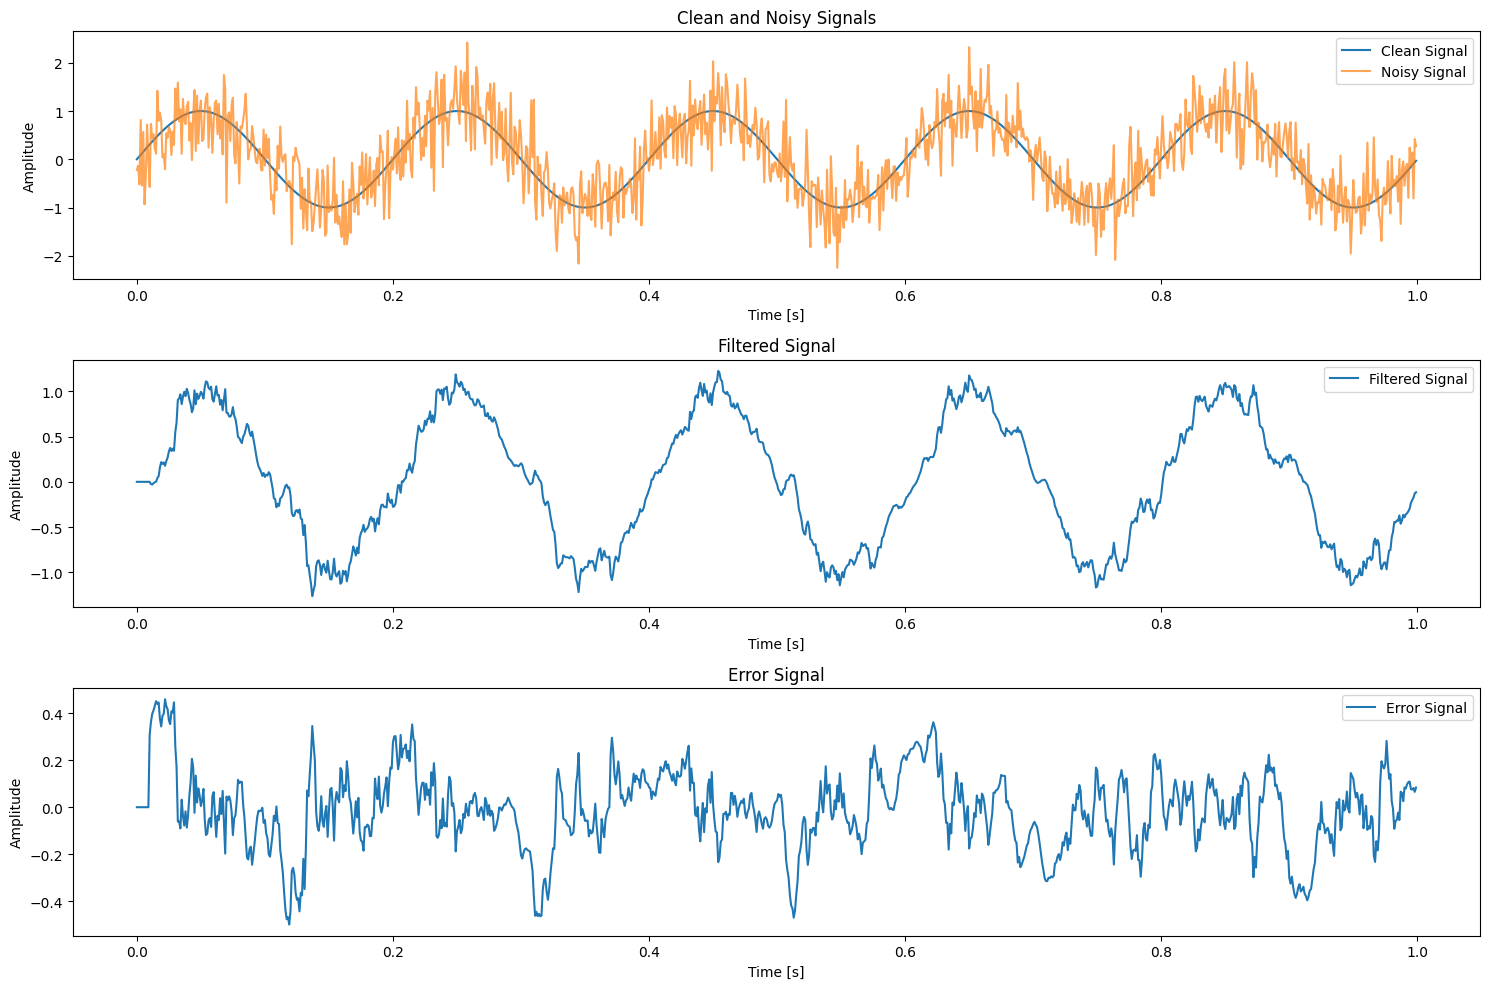

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Generate a clean signal and add noise to it
fs = 1000  # Sampling frequency
t = np.arange(0, 1, 1/fs)  # Time vector
freq = 5  # Frequency of the clean signal
clean_signal = np.sin(2 * np.pi * freq * t)  # Clean sinusoidal signal

# Add noise
noise = np.random.normal(0, 0.5, clean_signal.shape)
noisy_signal = clean_signal + noise

# Step 2: Define the LMS adaptive filter
def lms_filter(desired, input_signal, mu, filter_order):
    n_samples = len(input_signal)
    w = np.zeros(filter_order)  # Initialize filter weights
    y = np.zeros(n_samples)     # Initialize output signal
    e = np.zeros(n_samples)     # Initialize error signal

    for n in range(filter_order, n_samples):
        x = input_signal[n:n-filter_order:-1]  # Input vector
        y[n] = np.dot(w, x)                    # Filter output
        e[n] = desired[n] - y[n]               # Error signal
        w = w + 2 * mu * e[n] * x              # Update filter weights

    return y, e, w

# Step 3: Apply the LMS adaptive filter
mu = 0.02  # Step size (learning rate)
filter_order = 10  # Filter order (number of taps)
filtered_signal, error_signal, final_weights = lms_filter(clean_signal, noisy_signal, mu, filter_order)

# Step 4: Plot the results
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(t, clean_signal, label='Clean Signal')
plt.plot(t, noisy_signal, label='Noisy Signal', alpha=0.7)
plt.title('Clean and Noisy Signals')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t, filtered_signal, label='Filtered Signal')
plt.title('Filtered Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t, error_signal, label='Error Signal')
plt.title('Error Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()
